In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import Lasso

DATA_LOC = '../../../Data/microbiome_xai/'
DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"
FLUX_DF_NAME = "micom_medium-fluxes-top50-9285_samples_fd.csv"
FLUX_DF_NAME_all_FILT = "micom_fluxes-top50-9285_samples_fd_VEGAN-2000.csv"

gut_data = gd.GutData() # required to load for renaming metabolites as their id 
gut_data.load_data( 
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"
)

### Load flux dataframe
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, low_memory=False)
X_flux.index = X_flux.index.astype(str)
X_flux = mb_utils.drop_constant_cols(X_flux)

### Load large flux dataframe 
X_flux_notmedium = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME_all_FILT,index_col=0,low_memory=False)
X_flux_notmedium.index = X_flux_notmedium.index.astype(str)

### Get list of consumed columns
X_flux_consumed = X_flux[X_flux.columns[X_flux.mean()<0]].copy()
X_flux_consumed_cols = [x.replace("EX_", "").replace("_m__medium", "[e]") for x in X_flux_consumed.columns]
print("len(X_flux_consumed_cols):",len(X_flux_consumed_cols))

Fixed EX_tDHNACOA(e)
len(X_flux_consumed_cols): 464


In [2]:
BOOL_FLUX_NOTMEDIUM = False
SAVE_FIG = True

# SAVE_ID = "foodmetabs"
# SAVE_ID = "stdscale"
# SAVE_ID = "stdscale_50feats_c1"#"stdscale", "maxmin" # "minmax"
# SAVE_ID = "PARALLEL"
# SAVE_ID = "PARALLEL_std"
# SAVE_ID = "PARALLEL_std_noparams_5_100"
SAVE_ID = "PARALLEL_std-4_noparams_5_75"
# SAVE_ID = "notmedium_2000"

input_type_aucs_long = pd.read_csv(DIR_SIM_DATA+'ml_performance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_abundance_pheno_df = pd.read_csv(DIR_SIM_DATA+'imp_feat_abundance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_flux_pheno_df = pd.read_csv(DIR_SIM_DATA+'imp_feat_flux_%s_fd.csv'%(SAVE_ID), index_col=0)
flux_pheno_direct_df = pd.read_csv(DIR_SIM_DATA+'imp_flux_direction_%s_fd.csv'%(SAVE_ID), index_col=0)
flux_pheno_direct_df.columns = [x.split("_")[1]+"_"+x.split("_")[0] for x in flux_pheno_direct_df.columns]
food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df.csv',index_col=0)
# food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df_true.csv',index_col=0)
# food_matrix_df.drop(["salcn[e]"], inplace=True)

if BOOL_FLUX_NOTMEDIUM == False:
    imp_feat_flux_pheno_df_metab = mb_utils.get_metab_name_df(imp_feat_flux_pheno_df, gut_data)
    flux_pheno_direct_df_metab = mb_utils.get_metab_name_df(flux_pheno_direct_df, gut_data)
    
# Save performance table
SAVE_LOC = DIR_SIM_DATA+'performance_table_%s_fd.csv'%(SAVE_ID)
performance_table = mb_utils.plot_performance_table(input_type_aucs_long, SAVE_LOC, NO_DUMMY=True)
performance_table

,roc_auc,balanced_accuracy,average_precision,f1,f1_weighted
ibd_abundance,0.75±0.02,0.7±0.02,0.28±0.03,0.2±0.01,0.84±0.01
ibd_flux,0.67±0.03,0.63±0.03,0.14±0.03,0.15±0.01,0.8±0.02
ibs_abundance,0.58±0.02,0.56±0.01,0.19±0.01,0.26±0.01,0.62±0.01
ibs_flux,0.51±0.02,0.5±0.01,0.15±0.01,0.23±0.01,0.53±0.04
t2d_abundance,0.65±0.04,0.61±0.03,0.05±0.01,0.06±0.01,0.78±0.02
t2d_flux,0.5±0.04,0.51±0.04,0.02±0.0,0.04±0.01,0.72±0.03
vegan_abundance,0.73±0.04,0.68±0.03,0.07±0.02,0.1±0.01,0.83±0.01
vegan_flux,0.58±0.04,0.56±0.04,0.04±0.01,0.05±0.01,0.72±0.02


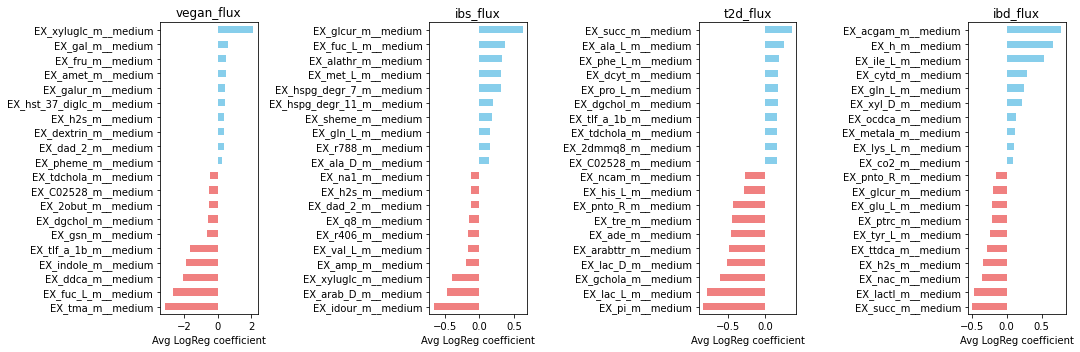

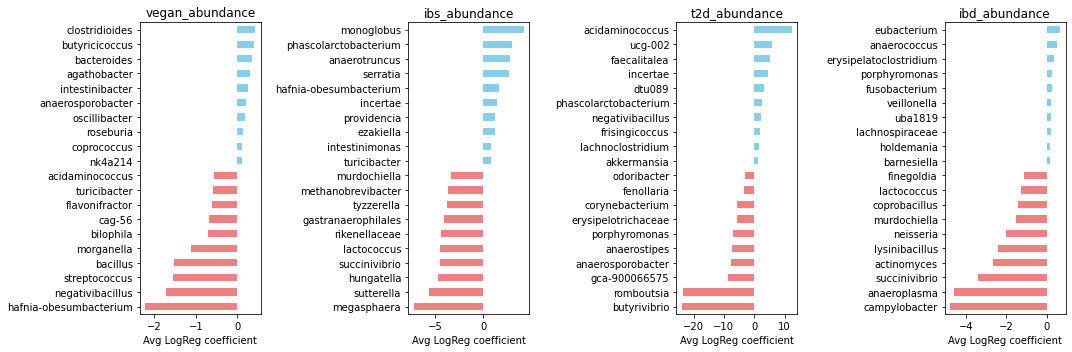

In [3]:
n_feats = 10

if BOOL_FLUX_NOTMEDIUM == False:
    imp_feat_flux_df = imp_feat_flux_pheno_df_metab
elif BOOL_FLUX_NOTMEDIUM ==True:
    imp_feat_flux_df = imp_feat_flux_pheno_df
    
# for input_type, input_df in [("flux", imp_feat_flux_pheno_df), ("abundance", imp_feat_abundance_pheno_df)]:
for input_type, input_df in [("flux", flux_pheno_direct_df ), ("abundance", imp_feat_abundance_pheno_df)]:

    f, ax = plt.subplots(1, len(input_df.columns), figsize=(15, n_feats/2)) # 5 works well for n_feats=10
    for i, col in enumerate(input_df.columns):
        top_pos_df = input_df[col].sort_values(ascending=False)[:n_feats][::-1]
        top_neg_df = input_df[col].sort_values(ascending=True)[:n_feats][::-1]
        top_df = pd.DataFrame(pd.concat([top_pos_df, top_neg_df]))
        top_df['positive'] = top_df[col] > 0
        top_df = top_df.sort_values(by=col,ascending=False)[::-1]
        top_df[col].plot(
            kind="barh", color=top_df.positive.map({True: 'skyblue', False: 'lightcoral'}), ax=ax[i])
        # abs(input_df)[col].sort_values(ascending=False)[:5][::-1].plot(kind="barh", ax=ax[i])
        ax[i].set_xlabel("Avg LogReg coefficient")
        ax[i].set_title("%s"%(col))

    if SAVE_FIG == True:
        f.tight_layout()
        f.savefig(gut_data.dir_sim_data+"figures/"+"LogReg_%s_feature_barh_fd_%s.svg"%(input_type, SAVE_ID))
        f.savefig(gut_data.dir_sim_data+"figures/"+"LogReg_%s_feature_barh_fd_%s.png"%(input_type, SAVE_ID))

Food inference

len(metab_overlap): 131
Non-zero feats (79,)
Non-zero feats (81,)
Non-zero feats (121,)
Non-zero feats (51,)


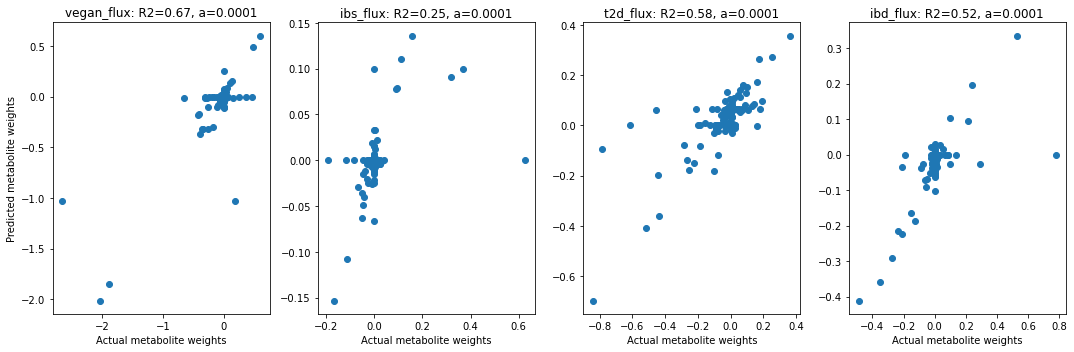

In [4]:
bool_concentrations=True
bool_direct_flux=True
bool_consumption=False
NORMALIZE=True # True
SAVE_ID_ALPHA = 4

SAVE_LOC_LASSO = DIR_SIM_DATA+"figures/"+"food_lasso_scatter_fd_%s_conc-%s_fluxdirect-%s_%s.svg"%(
    str(SAVE_ID_ALPHA), str(bool_concentrations), str(bool_direct_flux), SAVE_ID)

y_df, A_df = mb_utils.init_flux_food_df(
    imp_feat_flux_pheno_df.copy(), flux_pheno_direct_df.copy(), food_matrix_df, X_flux_consumed_cols, 
    bool_concentrations=bool_concentrations, bool_direct_flux=bool_direct_flux, bool_consumption=bool_consumption)

food_signal_df = mb_utils.food_lasso(
    y_df, A_df, SAVE_LOC_LASSO, SAVE_ID_ALPHA=SAVE_ID_ALPHA,SAVE_FIG=False,normalize=NORMALIZE)

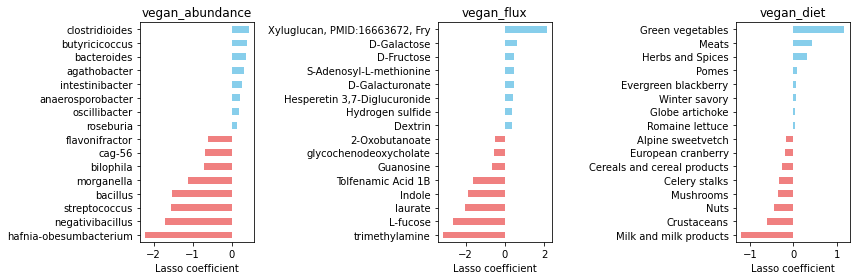

In [30]:
pheno="vegan"

n_feats=8
f, ax = plt.subplots(1, 3, figsize=(12, n_feats/2)) # 5 works well for n_feats=10
for i, (input_type, input_df) in enumerate([
    ("abundance", imp_feat_abundance_pheno_df), ("flux", flux_pheno_direct_df_metab ), ("diet", food_signal_df)
    # ("abundance", imp_feat_abundance_pheno_df), ("flux", imp_feat_flux_pheno_df_metab), ("diet", food_signal_df)
    ]):
    col = pheno+"_"+input_type
    if input_type=="diet":
        input_df.index = input_df.index.map(lambda x: x[:30] if len(x) > 25 else x)
        col = pheno+"_"+"flux"
    top_pos_df = input_df[col].sort_values(ascending=False)[:n_feats][::-1]
    top_neg_df = input_df[col].sort_values(ascending=True)[:n_feats][::-1]
    top_df = pd.DataFrame(pd.concat([top_pos_df, top_neg_df]))
    top_df['positive'] = top_df[col] > 0
    top_df = top_df.sort_values(by=col,ascending=False)[::-1]
    top_df[col].plot(
        kind="barh", color=top_df.positive.map({True: 'skyblue', False: 'lightcoral'}), ax=ax[i])
    # abs(input_df)[col].sort_values(ascending=False)[:5][::-1].plot(kind="barh", ax=ax[i])
    ax[i].set_xlabel("Lasso coefficient")
    if input_type=="diet":
        ax[i].set_title("%s"%(pheno+"_"+input_type))
    else:
        ax[i].set_title("%s"%(col))

if SAVE_FIG == True:
    f.tight_layout()
    f.savefig(gut_data.dir_sim_data+"figures/"+"key_feats_barh_%s_%s.png"%(pheno, SAVE_ID))
    f.savefig(gut_data.dir_sim_data+"figures/"+"key_feats_barh_%s_%s.svg"%(pheno, SAVE_ID))

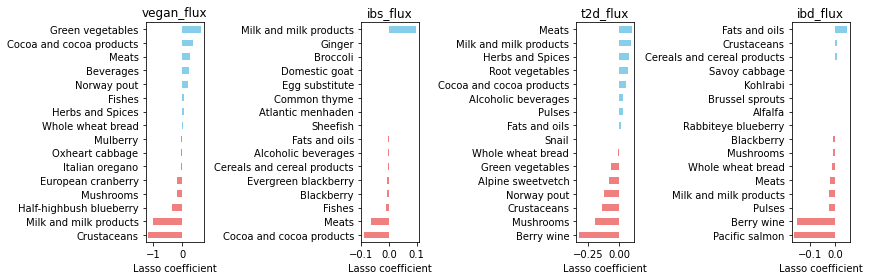

In [9]:
n_feats=8
input_df = food_signal_df.copy()
input_df.index = input_df.index.map(lambda x: x[:30] if len(x) > 25 else x)
f, ax = plt.subplots(1, len(input_df.columns), figsize=(12, n_feats/2)) # 5 works well for n_feats=10
# SAVE_ID="a3"
for i, col in enumerate(input_df.columns):
    top_pos_df = input_df[col].sort_values(ascending=False)[:n_feats][::-1]
    top_neg_df = input_df[col].sort_values(ascending=True)[:n_feats][::-1]
    top_df = pd.DataFrame(pd.concat([top_pos_df, top_neg_df]))
    top_df['positive'] = top_df[col] > 0
    top_df = top_df.sort_values(by=col,ascending=False)[::-1]
    top_df[col].plot(
        kind="barh", color=top_df.positive.map({True: 'skyblue', False: 'lightcoral'}), ax=ax[i])
    # abs(input_df)[col].sort_values(ascending=False)[:5][::-1].plot(kind="barh", ax=ax[i])
    ax[i].set_xlabel("Lasso coefficient")
    ax[i].set_title("%s"%(col))

if SAVE_FIG == True:
    f.tight_layout()
    f.savefig(gut_data.dir_sim_data+"figures/"+"foods_features_%s_barh_fd_conc-%s_fluxdirect-%s_%s.png"%(str(SAVE_ID_ALPHA), str(bool_concentrations), str(bool_direct_flux),SAVE_ID))
    f.savefig(gut_data.dir_sim_data+"figures/"+"foods_features_%s_barh_fd_conc-%s_fluxdirect-%s_%s.svg"%(str(SAVE_ID_ALPHA), str(bool_concentrations), str(bool_direct_flux),SAVE_ID))

# Hypergeometric enrichment approach
- Doesnt work as well...

In [52]:
from scipy.stats import hypergeom

In [100]:
def hypergeom_metab_foods(y_df, A_df, pheno_id, food_id, top_type="pos", n_top=20, verbose=True):
    top_neg_df = y_df[pheno_id].sort_values()[:n_top].copy()
    top_pos_df = y_df[pheno_id].sort_values()[-n_top:].copy()
    if top_type == "pos":
        metab_vector = top_pos_df
    elif top_type == "neg":
        metab_vector = top_neg_df

    # pvals_sig = mb_utils.get_pvalues(y_df[pheno_id], sig_cutoff=0.2)
    total_food_metabs = A_df.shape[1] # 931 (M)
    food_id_metabs = A_df[food_id][A_df[food_id]>0].shape[0] # - # of metabs in food id (n)
    total_signal_metabs = pvals_sig.shape[0] # - # of metabs in metabolite signal vector (N)

    metab_grp = list(metab_vector.index)
    food_metab_grp = list(A_df[food_id][A_df[food_id]>0].index)
    signal_metabs_in_food = len(list(set(food_metab_grp).intersection(metab_grp))) # (K)
    if verbose==True:
        print("k:%s, M:%s, n:%s, N:%s"%(signal_metabs_in_food, total_food_metabs, food_id_metabs, total_signal_metabs))
    pval = hypergeom.sf(signal_metabs_in_food, total_food_metabs, food_id_metabs, total_signal_metabs)
    # print(food_id, pheno_id, pval)
    return pval

In [97]:
N_TOP = 10
pheno_id = "vegan_flux"
pos_food_pval_dict, neg_food_pval_dict = {}, {}
for top_type in ["pos", "neg"]:
    for food_id in A_df.columns:
        pval = hypergeom_metab_foods(y_df, A_df, pheno_id, food_id, top_type=top_type, n_top=N_TOP, verbose=False)
        if top_type == "pos":
            pos_food_pval_dict.update({food_id: pval})
        elif top_type == "neg":
            neg_food_pval_dict.update({food_id: pval})

In [98]:
pos_df = pd.Series(pos_food_pval_dict,name="pos")
neg_df = pd.Series(neg_food_pval_dict,name="neg")
hypergeom_food_df = pd.concat([pos_df, neg_df],axis=1)

In [96]:
top_type="neg"
food_id = "Abalone"
hypergeom_metab_foods(y_df, A_df, pheno_id, food_id, top_type=top_type, n_top=N_TOP, verbose=True)

k:9, M:931, n:76, N:7


0.0

In [48]:
list(A_df[food_id][A_df[food_id]>0].index)

['ocdcea[e]',
 'chol[e]',
 'indole[e]',
 'thm[e]',
 '3mop[e]',
 'fuc_L[e]',
 'succ[e]',
 'acnam[e]']

In [74]:
list(set(food_metab_grp).intersection(metab_grp))

['succ[e]']

In [46]:
A_df[food_id][A_df[food_id]>0].shape[0]

8

In [35]:
y_df[pheno_id].sort_values()[-10:]

id
thymd[e]    0.078002
nac[e]      0.115110
asn_L[e]    0.142105
dpcoa[e]    0.157459
acnam[e]    0.185421
pheme[e]    0.263582
dad_2[e]    0.368012
galur[e]    0.465596
fru[e]      0.486696
gal[e]      0.596905
Name: vegan_flux, dtype: float64

In [37]:
top_neg_df

id
fuc_L[e]    -2.660870
ddca[e]     -2.044167
indole[e]   -1.885263
gsn[e]      -0.645251
arab_L[e]   -0.426121
tre[e]      -0.403494
gly[e]      -0.393305
na1[e]      -0.347822
pnto_R[e]   -0.343646
taur[e]     -0.308800
Name: vegan_flux, dtype: float64

In [43]:
A_df.loc[top_neg_df.index][food_id]

id
fuc_L[e]     1.0
ddca[e]      0.0
indole[e]    1.0
gsn[e]       0.0
arab_L[e]    0.0
tre[e]       0.0
gly[e]       0.0
na1[e]       0.0
pnto_R[e]    0.0
taur[e]      0.0
Name: Milk and milk products, dtype: float64

In [36]:
top_neg_df = y_df[pheno_id].sort_values()[:10].copy()
top_neg_df.loc[A_df[food_id][A_df[food_id]>0].index]

KeyError: "None of [Index(['spmd[e]', 'chol[e]', 'thm[e]', 'succ[e]', 'alahis[e]'], dtype='object', name='source_id')] are in the [index]"

In [38]:
food_id = "Milk and milk products"
y_df.loc[A_df[food_id][A_df[food_id]>0].index]

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
source_id,,,,
ocdcea[e],0.000000,0.000000,-0.018786,0.000000
chol[e],0.000000,-0.000664,0.058275,0.000000
indole[e],-1.885263,0.000000,0.043915,0.000000
thm[e],0.000000,0.001592,-0.023726,0.000000
3mop[e],0.009192,0.000000,0.095264,0.000000
fuc_L[e],-2.660870,0.367192,-0.036003,0.000000
succ[e],-0.175607,0.000000,0.363954,-0.488814
acnam[e],0.185421,0.000000,0.140060,0.000000


In [26]:
pvals_sig.shape

(7,)

In [ ]:
p = stats.hypergeom.sf(x, N, k, m)

In [14]:
y_df

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
id,,,,
nh4[e],-0.032421,-0.065210,-0.045760,-0.006655
arbt[e],0.037385,0.000000,-0.084649,0.000000
ocdcea[e],0.000000,0.000000,-0.018786,0.000000
glyc[e],0.002156,-0.004250,0.010067,0.000000
dad_2[e],0.368012,-0.115541,0.009589,0.000000
...,...,...,...,...
alahis[e],0.000000,-0.051349,-0.002400,-0.005483
dcyt[e],0.000000,0.010760,0.178552,-0.018076
fru[e],0.486696,0.000000,0.002872,-0.003982


In [15]:
food_id = "Milk and milk products"
y_df.loc[A_df[food_id][A_df[food_id]>0].index]

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
source_id,,,,
ocdcea[e],0.000000,0.000000,-0.018786,0.000000
chol[e],0.000000,-0.000664,0.058275,0.000000
indole[e],-1.885263,0.000000,0.043915,0.000000
thm[e],0.000000,0.001592,-0.023726,0.000000
3mop[e],0.009192,0.000000,0.095264,0.000000
fuc_L[e],-2.660870,0.367192,-0.036003,0.000000
succ[e],-0.175607,0.000000,0.363954,-0.488814
acnam[e],0.185421,0.000000,0.140060,0.000000


In [16]:
food_id = "Meats"
y_df.loc[A_df[food_id][A_df[food_id]>0].index]

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
source_id,,,,
spmd[e],0.000000,0.000000,0.010289,0.000000
chol[e],0.000000,-0.000664,0.058275,0.000000
thm[e],0.000000,0.001592,-0.023726,0.000000
succ[e],-0.175607,0.000000,0.363954,-0.488814
alahis[e],0.000000,-0.051349,-0.002400,-0.005483


# Network Visualization

In [31]:
import networkx as nx
from scipy import stats

def get_node_colors(G, imp_feat_flux_pheno_df, imp_feat_abundance_pheno_df, pheno="vegan",cutoff_val = 0.05):
    color_map = []
    node_2color_dict = {}
    for node in G:
        # print(node)
        color_id=None
        for input_type, input_df in [("flux", imp_feat_flux_pheno_df), ("abundance", imp_feat_abundance_pheno_df)]:
            if node in input_df[pheno+"_"+input_type].index:
                if input_df[pheno+"_"+input_type].loc[node]>cutoff_val :
                    color_id = 'skyblue'
                elif input_df[pheno+"_"+input_type].loc[node]<-cutoff_val :
                    color_id = 'lightcoral'
                else:
                    color_id = "grey"
                color_map.append(color_id)
                node_2color_dict.update({node: color_id})
        if color_id==None:
            color_map.append("grey")
            node_2color_dict.update({node: "grey"})
            
    return node_2color_dict, color_map


def genera_flux_corr(medium_react, gut_data, X_flux_notmedium,pheno="vegan",SAMPLE_NUM=10000,scale=True):
    # medium_react = "EX_sprm_m__medium"#"EX_ind3ppa_m"# "EX_tma_m__medium"#"EX_fuc_L_m__medium"
    metab_id = medium_react.replace("EX_","").replace("__medium","")
    react_ids = [x.id for x in gut_data.com_model.metabolites.get_by_id(metab_id).reactions if "medium exchange" not in x.name]
    # print(X_flux_notmedium[react_ids].mean().sort_values())
    
    if pheno=="vegan":
        gut_data.set_vegan_df(sample_num=SAMPLE_NUM)
    elif pheno=="ibs":
        gut_data.set_ibs_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
    elif pheno=="t2d":
        gut_data.set_t2d_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
    elif pheno=="ibd":
        gut_data.set_ibd_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
    y_df = gut_data.y_df.copy()
    X, y = mb_utils.match_Xy_df(X_flux_notmedium, y_df)
                
    if len(react_ids)==1:
        print("yes:",X[react_ids[0]].loc[y[y==1].index].mean())
        print("no:",X[react_ids[0]].loc[y[y==0].index].mean())
    else:
        yes_series = X[react_ids].loc[y[y==1].index].mean().sort_values()
        yes_series.name = "yes"
        no_series = X[react_ids].loc[y[y==0].index].mean().sort_values()
        no_series.name = "no"
        yes_no_df = pd.concat([yes_series, no_series],axis=1)
        print(yes_no_df)
        # print("yes:",X[react_ids].loc[y[y==1].index].mean().sort_values())
        # print("no:",X[react_ids].loc[y[y==0].index].mean().sort_values())

    SCALE_TYPE=StandardScaler()
    X = X[react_ids].copy()
    if scale==True:
        X_scale = SCALE_TYPE.fit_transform(X)
        f_stat, p_val = f_classif(X_scale, y)
    else:
        f_stat, p_val = f_classif(X, y)
    #fclass_df = pd.DataFrame(f_stat, index=X.columns, columns=["f_stat"])
    fclass_pval_df = pd.Series(p_val, index=X.columns)
    fclass_pval_df.name = "pval"
    # fclass_df = pd.DataFrame([f_stat, p_val], index=X.columns, columns=["f_stat", "p_val"])
    fclass_pval_df.sort_values(inplace=True)
    return fclass_pval_df

def plot_nx_genera_flux(SAVE_ID, df_pheno, imp_feat_flux, imp_feat_abundance_pheno_df, pheno="vegan", cutoff_val = 0.2, SAVE_FIG=False):
    f, ax = plt.subplots(1,1,figsize=(5,4))
    G = nx.Graph()
    left_nodes = list(set(df_pheno.stack().reset_index()["level_0"].values))
    right_nodes = list(set(df_pheno.stack().reset_index()["level_1"].values))
    max_node_height = max(len(left_nodes), len(right_nodes))
    G.add_nodes_from(left_nodes, bipartite=0) # Add the node attribute "bipartite"
    G.add_nodes_from(right_nodes, bipartite=1)
    # G.add_nodes_from(right_nodes, bipartite=2)
    # B.add_edges_from([(1,'a'), (1,'b'), (2,'b'), (2,'c'), (3,'c'), (4,'a')])
    # B.add_edges_from(
    #     [(idx[0], idx[1]) for idx, row in df_pheno.stack().iteritems()])
    G.add_weighted_edges_from(
        [(idx[0], idx[1], row) for idx, row in df_pheno.stack().iteritems()], 
        weight='weight')
    # G.add_weighted_edges_from(
    #     [(idx[1], idx[0], row) for idx, row in df_pheno.stack().iteritems()], 
    #     weight='weight')

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    edge_colors = ["purple" if x >0 else "orange" for x in weights]
    # Separate by group
    # print(B.edges(data=True))

    pos = {node:[0, i-len(left_nodes)/2] for i,node in enumerate(left_nodes)}
    pos.update({node:[1, i-len(right_nodes)/2] for i,node in enumerate(right_nodes)})
    # pos.update({node:[2, i-len(right_nodes)/2] for i,node in enumerate(left_nodes)})
    node_2color_dict, color_map = get_node_colors(
        G, imp_feat_flux, imp_feat_abundance_pheno_df, pheno=pheno,cutoff_val =cutoff_val)
    print(node_2color_dict)
    nx.draw(
        G, pos, with_labels=False, 
        node_color=color_map, 
        edge_color=edge_colors,
        width=1.0,node_size=300, arrows=True)
    for p in pos:  # raise text positions
        pos[p][1] += 0.25
        
    # for edge in G.edges(data=True):
    #     w = edge[2]['weight']
    #     nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], arrowsize=100)
    # plt.show()
    nx.draw_networkx_labels(G, pos)

    #plt.tight_layout()
    f.tight_layout()
    plt.margins(x=0.4,y=0.4)
    #plt.show()
    if SAVE_FIG == SAVE_FIG:
        f.savefig(gut_data.dir_sim_data+"figures/"+"genus_flux_networkx_%s.svg"%(SAVE_ID))
        f.savefig(gut_data.dir_sim_data+"figures/"+"genus_flux_networkx_%s.png"%(SAVE_ID))

In [36]:
PHENO = "vegan"
SIG_CUTOFF_REACTS = 0.3
SIG_CUTOFF_GENERA = 0.05
SCALE_ = False # doesnt do anything...
BOOL_DIRECT_FLUX = True

if BOOL_DIRECT_FLUX == True:
    imp_feat_flux = flux_pheno_direct_df.copy()
else:
    imp_feat_flux = imp_feat_flux_pheno_df.copy()
    
pheno_sigreacts_dict = mb_utils.get_sigreacts_dict(
    X_flux, imp_feat_flux, gut_data,SAMPLE_NUM=10000,SIG_CUTOFF=SIG_CUTOFF_REACTS)
df_pheno = mb_utils.get_sig_genus_exchange_CORR(
    pheno_sigreacts_dict, X_flux_notmedium, imp_feat_flux,gut_data,
    pheno=PHENO,SAMPLE_NUM=10000,scale=SCALE_, SIG_CUTOFF=SIG_CUTOFF_GENERA)
df_pheno

/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 2  3  7 10 11 14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,EX_tma_m__medium,EX_fuc_L_m__medium,EX_xyluglc_m__medium,EX_ddca_m__medium,EX_indole_m__medium,EX_tlf_a_1b_m__medium,EX_gal_m__medium,EX_fru_m__medium,EX_gsn_m__medium,EX_amet_m__medium,EX_galur_m__medium,EX_hst_37_diglc_m__medium
streptococcus,0.01419,NaN,NaN,NaN,NaN,NaN,NaN,39.660731,NaN,-0.200894,NaN,NaN
ruminococcus,NaN,0.003943,-0.000067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alistipes,NaN,NaN,NaN,-0.102155,NaN,NaN,NaN,0.000003,-0.016894,NaN,NaN,NaN
flavonifractor,NaN,NaN,NaN,NaN,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parabacteroides,NaN,NaN,NaN,NaN,NaN,NaN,0.876824,NaN,NaN,NaN,NaN,NaN
roseburia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.043680,NaN,NaN,NaN,NaN
butyricicoccus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010122,NaN,NaN,NaN,NaN
enterococcus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003904,NaN,NaN


In [13]:
A_df["Meats"].sort_values()

source_id
nh4[e]       0.0
fuc_L[e]     0.0
pyr[e]       0.0
for[e]       0.0
meoh[e]      0.0
            ... 
chol[e]      1.0
succ[e]      1.0
spmd[e]      1.0
alahis[e]    1.0
thm[e]       1.0
Name: Meats, Length: 131, dtype: float64

{'flavonifractor': 'lightcoral', 'ruminococcus': 'lightcoral', 'roseburia': 'grey', 'butyricicoccus': 'skyblue', 'enterococcus': 'grey', 'streptococcus': 'lightcoral', 'alistipes': 'lightcoral', 'parabacteroides': 'grey', 'EX_xyluglc_m__medium': 'skyblue', 'EX_amet_m__medium': 'skyblue', 'EX_ddca_m__medium': 'lightcoral', 'EX_fuc_L_m__medium': 'lightcoral', 'EX_indole_m__medium': 'lightcoral', 'EX_gsn_m__medium': 'lightcoral', 'EX_fru_m__medium': 'skyblue', 'EX_tma_m__medium': 'lightcoral', 'EX_gal_m__medium': 'skyblue'}


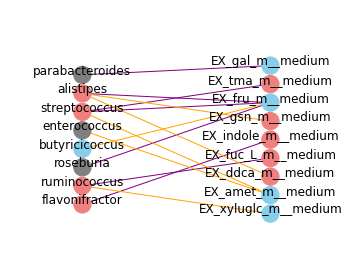

In [37]:
plot_nx_genera_flux(
    SAVE_ID, df_pheno, imp_feat_flux, imp_feat_abundance_pheno_df, pheno="vegan", cutoff_val=0.2, SAVE_FIG=False)

In [38]:
# medium_react = "EX_sprm_m__medium"
medium_react = "EX_gal_m__medium"
# medium_react = "EX_xyluglc_m__medium"#"EX_indole_m__medium"#"EX_ddca_m__medium"#"EX_fuc_L_m__medium"#"EX_tma_m__medium"
react_corr = genera_flux_corr(medium_react, gut_data, X_flux_notmedium, pheno="vegan", scale=False, SAMPLE_NUM=10000)
react_corr

                                      yes         no
EX_gal(e)__tyzzerella           -0.000115  -0.000107
EX_gal(e)__butyrivibrio         -0.000103  -0.000095
EX_gal(e)__veillonella          -0.000023  -0.000023
EX_gal(e)__providencia          -0.000022  -0.000023
EX_gal(e)__collinsella          -0.000016  -0.000017
EX_gal(e)__oscillibacter        -0.000014  -0.000014
EX_gal(e)__lachnoclostridium    -0.000013  -0.000014
EX_gal(e)__lachnospira          -0.000013  -0.000013
EX_gal(e)__intestinibacter      -0.000013  -0.000013
EX_gal(e)__erysipelotrichaceae  -0.000010  -0.000011
EX_gal(e)__flavonifractor       -0.000010  -0.000010
EX_gal(e)__fusicatenibacter     -0.000009  -0.000009
EX_gal(e)__romboutsia           -0.000009  -0.000009
EX_gal(e)__haemophilus           0.000007   0.000008
EX_gal(e)__faecalibacterium      0.000056   0.000065
EX_gal(e)__paraprevotella        0.000064   0.000067
EX_gal(e)__butyricicoccus        0.000114   0.000116
EX_gal(e)__stenotrophomonas      0.000119   0.

EX_gal(e)__parabacteroides        0.010049
EX_gal(e)__faecalibacterium       0.225774
EX_gal(e)__bifidobacterium        0.226165
EX_gal(e)__roseburia              0.248767
EX_gal(e)__clostridium            0.275247
EX_gal(e)__collinsella            0.323977
EX_gal(e)__butyrivibrio           0.406113
EX_gal(e)__coprococcus            0.497540
EX_gal(e)__flavonifractor         0.509918
EX_gal(e)__subdoligranulum        0.530629
EX_gal(e)__akkermansia            0.583700
EX_gal(e)__paraprevotella         0.589842
EX_gal(e)__streptococcus          0.591484
EX_gal(e)__lachnoclostridium      0.597568
EX_gal(e)__prevotella             0.621060
EX_gal(e)__haemophilus            0.628009
EX_gal(e)__fusicatenibacter       0.645223
EX_gal(e)__romboutsia             0.653966
EX_gal(e)__pseudomonas            0.655581
EX_gal(e)__providencia            0.657944
EX_gal(e)__corynebacterium        0.663703
EX_gal(e)__intestinibacter        0.701867
EX_gal(e)__bacteroides            0.704536
EX_gal(e)__

Metabolites to foods network

In [53]:
input_type = "vegan_flux"#"flux_vegan"
sig_food_metabs = mb_utils.get_pvalues(y_df[input_type].sort_values(), sig_cutoff=0.2)
sig_food_metabs = y_df[input_type].sort_values().loc[sig_food_metabs.index]
sig_food_metabs.name = input_type
# sig_genus_exchange.index = sig_genus_exchange.index.map(lambda x: x.split("__")[1])
sig_food_metabs

id
fuc_L[e]    -2.660870
ddca[e]     -2.044167
indole[e]   -1.885263
gal[e]       0.596905
gsn[e]      -0.645251
fru[e]       0.486696
galur[e]     0.465596
Name: vegan_flux, dtype: float64

In [39]:
SIG_CUTOFF_METABS = 0.2
SIG_CUTOFF_FOODS = 0.05
# input_type = "flux_vegan"
input_type = "vegan_flux"

sig_food_metabs = mb_utils.get_pvalues(y_df[input_type].sort_values(), sig_cutoff=SIG_CUTOFF_METABS)
sig_food_metabs = y_df[input_type].sort_values().loc[sig_food_metabs.index]
sig_food_metabs.name = input_type

df_sig_foods = pd.DataFrame()
for sig_food_metab in sig_food_metabs.index:
    sig_foods = mb_utils.get_pvalues(A_df.loc[sig_food_metab], sig_cutoff=SIG_CUTOFF_FOODS)
    sig_foods.name = sig_food_metab
    df_sig_foods = pd.concat([df_sig_foods, sig_foods],axis=1)
df_sig_foods

,fuc_L[e],ddca[e],indole[e],gal[e],gsn[e],fru[e],galur[e]
Milk (Cow),3.370022e-202,NaN,NaN,1.207043e-31,NaN,NaN,NaN
Babassu palm,NaN,3.411418e-100,NaN,NaN,NaN,NaN,NaN
Oil palm,NaN,3.847137e-59,NaN,NaN,NaN,NaN,NaN
Coconut,NaN,1.727670e-32,NaN,NaN,NaN,NaN,1.505841e-10
Ucuhuba,NaN,1.396862e-07,NaN,NaN,NaN,NaN,NaN
Sour cream,NaN,9.689622e-05,NaN,NaN,NaN,NaN,NaN
Coffee mocha,NaN,7.181535e-03,NaN,NaN,NaN,NaN,NaN
Taro,NaN,NaN,NaN,2.440463e-152,NaN,NaN,NaN
Honey,NaN,NaN,NaN,4.361692e-10,NaN,4.584889e-82,NaN
Dulce de leche,NaN,NaN,NaN,3.801834e-05,NaN,NaN,NaN


In [45]:
A_df["Milk and milk products"][A_df["Milk and milk products"]>0]

source_id
chol[e]      1.0
thm[e]       1.0
acnam[e]     1.0
succ[e]      1.0
fuc_L[e]     1.0
3mop[e]      1.0
ocdcea[e]    1.0
indole[e]    1.0
Name: Milk and milk products, dtype: float64

In [47]:
food_id = "Milk and milk products"
y_df.loc[A_df[food_id][A_df[food_id]>0].index]

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
source_id,,,,
chol[e],0.000000,-0.000664,0.058275,0.000000
thm[e],0.000000,0.001592,-0.023726,0.000000
acnam[e],0.185421,0.000000,0.140060,0.000000
succ[e],-0.175607,0.000000,0.363954,-0.488814
fuc_L[e],-2.660870,0.367192,-0.036003,0.000000
3mop[e],0.009192,0.000000,0.095264,0.000000
ocdcea[e],0.000000,0.000000,-0.018786,0.000000
indole[e],-1.885263,0.000000,0.043915,0.000000


In [52]:
food_id = "Meats"
y_df.loc[A_df[food_id][A_df[food_id]>0].index]

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
source_id,,,,
chol[e],0.000000,-0.000664,0.058275,0.000000
thm[e],0.000000,0.001592,-0.023726,0.000000
succ[e],-0.175607,0.000000,0.363954,-0.488814
spmd[e],0.000000,0.000000,0.010289,0.000000
alahis[e],0.000000,-0.051349,-0.002400,-0.005483


In [51]:
food_id = "Green vegetables"
y_df.loc[A_df[food_id][A_df[food_id]>0].index]["vegan_flux"].sort_values()

source_id
ddca[e]     -2.044167
indole[e]   -1.885263
gsn[e]      -0.645251
gly[e]      -0.393305
cytd[e]     -0.308530
               ...   
glyclt[e]    0.039522
lac_D[e]     0.053943
nac[e]       0.115110
asn_L[e]     0.142105
dpcoa[e]     0.157459
Name: vegan_flux, Length: 73, dtype: float64

In [54]:
A_df==0

,Abalone,Abiyuch,Acerola,Acorn,Acorn squash,Adobo,Adzuki bean,Agar,Agave,Akutaq,...,Yautia,Yellow bell pepper,Yellow pond-lily,Yellow wax bean,Yellow zucchini,Yellowfin tuna,Yellowtail amberjack,Ymer,Yogurt,Zwieback
source_id,,,,,,,,,,,,,,,,,,,,,
glcn[e],True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
glu_L[e],False,False,False,False,True,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
cobalt2[e],True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,False,True,True,True,True,True
hdca[e],False,False,False,False,True,True,False,False,False,True,...,False,False,False,False,False,True,True,True,True,True
phe_L[e],True,True,True,True,True,True,True,True,True,True,...,True,False,True,False,False,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ocdca[e],True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
duri[e],False,False,False,False,True,True,False,False,False,True,...,False,False,False,False,False,True,True,True,True,True
pnto_R[e],True,True,True,True,True,True,True,True,True,True,...,True,False,True,False,True,True,True,True,True,True


In [64]:
df_sig_foods.loc["Meats"]

KeyError: 'Meats'

In [19]:
A_df.loc["fuc_L[e]"].sort_values(ascending=False)[:20]

Milk (Cow)      26.016364
Abalone          0.000000
Pili nut         0.000000
Persian lime     0.000000
Persimmon        0.000000
Phyllo dough     0.000000
Pie              0.000000
Pie crust        0.000000
Pie filling      0.000000
Pigeon pea       0.000000
Pikeperch        0.000000
Piki bread       0.000000
Pine nut         0.000000
Perciformes      0.000000
Pineapple        0.000000
Pink salmon      0.000000
Pistachio        0.000000
Pita bread       0.000000
Pitanga          0.000000
Pizza            0.000000
Name: fuc_L[e], dtype: float64

In [20]:
A_df.loc["ddca[e]"].sort_values(ascending=False)[:40]

Babassu palm           43500.000000
Oil palm               33244.583333
Coconut                25320.001923
Ucuhuba                10925.000000
Sour cream              8138.000000
Coffee mocha            5672.000000
Cream substitute        3788.636364
Milk (Cow)              3559.992805
Topping                 3204.545455
Corn chip               3166.250000
Butterfat               2793.000000
Butter                  2476.777778
Candy bar               2279.875000
Shortening              2241.352941
Trail mix               1744.000000
Snack bar               1686.000000
Other candy             1612.152542
Cocktail                1403.000000
Shea tree               1300.000000
Margarine               1237.692308
Other snack food         804.596154
Date                     745.250000
Cheese                   738.025510
Milk substitute          710.500000
Chocolate                691.187500
Tostada                  612.000000
Nutmeg                   594.791667
Cream                    553

In [ ]:
# medium_react = "EX_sprm_m__medium"
medium_react = "EX_fuc_L_m__medium"#"EX_indole_m__medium"#"EX_ddca_m__medium"#"EX_fuc_L_m__medium"#"EX_tma_m__medium"
react_corr = genera_flux_corr(medium_react, gut_data, X_flux_notmedium, pheno="vegan", scale=False, SAMPLE_NUM=10000)
react_corr

In [28]:
# medium_react = "EX_sprm_m__medium"
medium_react = "EX_fuc_L_m__medium"
print_genera_flux_distribution(medium_react, gut_data, X_flux_notmedium, pheno="vegan", SAMPLE_NUM=100)

EX_fuc_L(e)__blautia           -0.000039
EX_fuc_L(e)__subdoligranulum   -0.000027
EX_fuc_L(e)__bifidobacterium   -0.000024
EX_fuc_L(e)__roseburia         -0.000022
EX_fuc_L(e)__akkermansia       -0.000018
EX_fuc_L(e)__bacteroides        0.000006
EX_fuc_L(e)__clostridium        0.000140
EX_fuc_L(e)__ruminococcus       0.003943
EX_fuc_L(e)__dysgonomonas       0.006371
dtype: float64
yes: EX_fuc_L(e)__blautia           -0.000036
EX_fuc_L(e)__subdoligranulum   -0.000025
EX_fuc_L(e)__bifidobacterium   -0.000022
EX_fuc_L(e)__roseburia         -0.000021
EX_fuc_L(e)__akkermansia       -0.000017
EX_fuc_L(e)__bacteroides        0.000005
EX_fuc_L(e)__clostridium        0.000128
EX_fuc_L(e)__ruminococcus       0.003199
EX_fuc_L(e)__dysgonomonas       0.006250
dtype: float64
no: EX_fuc_L(e)__blautia           -0.000034
EX_fuc_L(e)__subdoligranulum   -0.000024
EX_fuc_L(e)__bifidobacterium   -0.000021
EX_fuc_L(e)__roseburia         -0.000020
EX_fuc_L(e)__akkermansia       -0.000016
EX_fuc_L(e)__bacte

In [31]:
# medium_react = "EX_sprm_m__medium"
medium_react = "EX_tma_m__medium"
print_genera_flux_distribution(medium_react, gut_data, X_flux_notmedium, pheno="vegan", SAMPLE_NUM=100)

EX_tma(e)__sutterella      -1.730918e-04
EX_tma(e)__haemophilus     -7.372554e-05
EX_tma(e)__providencia      9.086625e-07
EX_tma(e)__coprococcus      2.826716e-05
EX_tma(e)__bacteroides      3.953545e-05
EX_tma(e)__pseudomonas      4.311740e-05
EX_tma(e)__dorea            5.236387e-05
EX_tma(e)__enterococcus     1.624334e-04
EX_tma(e)__clostridium      3.621232e-04
EX_tma(e)__bilophila        7.244313e-03
EX_tma(e)__streptococcus    1.419027e-02
dtype: float64
yes: EX_tma(e)__sutterella      -1.627187e-04
EX_tma(e)__haemophilus     -7.002338e-05
EX_tma(e)__providencia      7.338928e-07
EX_tma(e)__coprococcus      2.652673e-05
EX_tma(e)__pseudomonas      3.958147e-05
EX_tma(e)__bacteroides      4.030426e-05
EX_tma(e)__dorea            4.931663e-05
EX_tma(e)__enterococcus     1.583145e-04
EX_tma(e)__clostridium      2.491094e-04
EX_tma(e)__bilophila        4.687661e-03
EX_tma(e)__streptococcus    7.113620e-03
dtype: float64
no: EX_tma(e)__sutterella      -1.499127e-04
EX_tma(e)__haemoph

In [77]:
# medium_react = "EX_sprm_m__medium"
medium_react = "EX_xyluglc_m__medium"#"EX_indole_m__medium"#"EX_ddca_m__medium"#"EX_fuc_L_m__medium"#"EX_tma_m__medium"
react_corr = genera_flux_corr(medium_react, gut_data, X_flux_notmedium, pheno="vegan", scale=False, SAMPLE_NUM=10000)
react_corr

                                      yes            no
EX_xyluglc(e)__dysgonomonas -1.054491e-04 -1.062566e-04
EX_xyluglc(e)__ruminococcus -5.410751e-05 -6.803159e-05
EX_xyluglc(e)__bacteroides  -4.299708e-07 -4.474335e-07


EX_xyluglc(e)__ruminococcus    0.016083
EX_xyluglc(e)__bacteroides     0.652133
EX_xyluglc(e)__dysgonomonas    0.730567
Name: pval, dtype: float64

In [24]:
imp_feat_flux_df.loc["EX_tma(e)__streptococcus"]

KeyError: 'EX_tma(e)__streptococcus'

In [22]:
gut_data.com_model.metabolites.get_by_id("tma_m")

Metabolite identifier,tma_m
Name,trimethylamine
Memory address,0x07f44d46d8c70
Formula,C3H10N
Compartment,m
In 12 reaction(s),"EX_tma(e)__streptococcus, EX_tma(e)__bacteroides, EX_tma(e)__haemophilus, EX_tma(e)__dorea, EX_tma(e)__pseudomonas, EX_tma(e)__enterococcus, EX_tma(e)__providencia, EX_tma(e)__sutterella,..."


In [20]:
gut_data.com_model.metabolites.get_by_id("tma[e]__streptococcus")

Metabolite identifier,tma[e]__streptococcus
Name,trimethylamine
Memory address,0x07f44bb4927f0
Formula,C3H10N
Compartment,e__streptococcus
In 2 reaction(s),"TMAt2r__streptococcus, EX_tma(e)__streptococcus"
